In [5]:
import os
import torch
import random
import argparse
import warnings

from peft import AutoPeftModelForCausalLM
from trl import setup_chat_format, SFTTrainer
from datasets import load_dataset, disable_caching
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, TrainingArguments, pipeline

from codecarbon import EmissionsTracker

from utils import init_wandb, build_prompts, get_preds, get_labels, evaluate

warnings.filterwarnings("ignore")

In [6]:
# Free CUDA memory
torch.cuda.empty_cache()

ADAPTER_ID = "kahliahogg/climate-peft"
BASE_ID = "eci-io/climategpt-7b"

# GPU/CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Running evaluation on {device}")

# Load test dataset
test_prompts = load_dataset("json", data_files="data/test_prompts.json", split="train")
print(f"Loaded {test_prompts.num_rows} test samples")

Running evaluation on cuda:0
Loaded 320 test samples


### Evaluate Baseline Model

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 320/320 [00:00<00:00, 24942.43it/s]


Test recall: 0.68125
Test precision: 0.68125
Test f1: 0.68125
Test accuracy: 0.68125


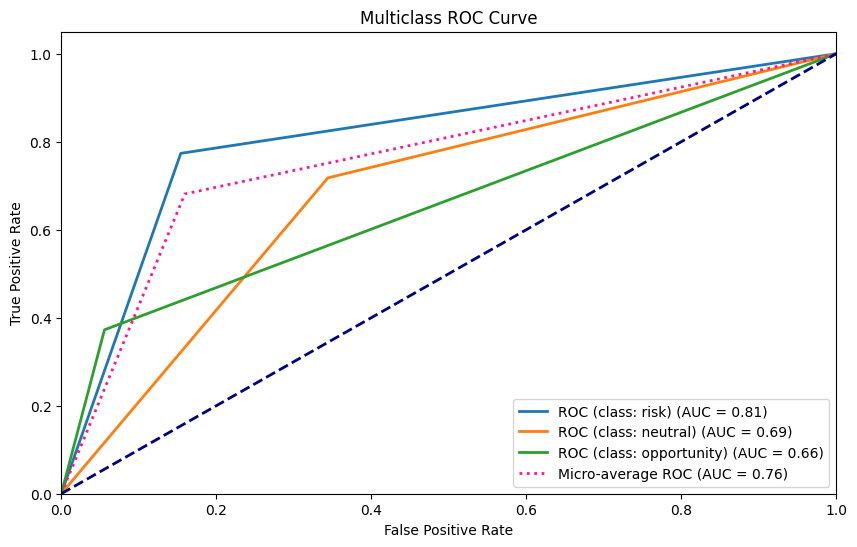

In [9]:
base_tracker = EmissionsTracker(project_name=BASE_ID)

tokenizer = AutoTokenizer.from_pretrained(BASE_ID)
model = AutoModelForCausalLM.from_pretrained(BASE_ID)

# ChatML Config
model, tokenizer = setup_chat_format(model, tokenizer)

# Load merged model into pipeline
pipe = pipeline(
    task="text-generation", 
    model=model, 
    tokenizer=tokenizer
)

# Test Preds
base_tracker.start()
y_preds = get_preds(test_prompts, pipe)
base_co2 = base_tracker.stop()
y_true = get_labels(test_prompts)

# Evaluate
evaluate(y_true, y_preds, ".", log_to_wandb=False)

print(f"Average CO2 emissions/inference: {base_co2/len(y_preds)}")

### Evaluate Finetuned Model

In [10]:
# Free CUDA memory..again
del model
del tokenizer
torch.cuda.empty_cache()

peft_tracker = EmissionsTracker(project_name=ADAPTER_ID)

# Load model with PEFT adapter
model = AutoPeftModelForCausalLM.from_pretrained(
    ADAPTER_ID,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    device_map=device,
)

tokenizer = AutoTokenizer.from_pretrained(ADAPTER_ID)

# Load merged model into pipeline
pipe = pipeline(
    task="text-generation", 
    model=model, 
    tokenizer=tokenizer
)

# Test Preds
peft_tracker.start()
y_preds = get_preds(test_prompts, pipe)
peft_co2 = peft_tracker.stop()
y_true = get_labels(test_prompts)

# Evaluate
evaluate(y_true, y_preds, ".", log_to_wandb=False)

print(f"Average CO2 emissions/inference: {peft_co2/len(y_preds)}")

RepositoryNotFoundError: 404 Client Error. (Request ID: Root=1-65f8f753-34c5e4d9567e28641731bc69;8c1c8557-55bd-49b2-a437-54be5c9be2cc)

Repository Not Found for url: https://huggingface.co/kahliahogg/climate-test/resolve/main/adapter_model.bin.
Please make sure you specified the correct `repo_id` and `repo_type`.
If you are trying to access a private or gated repo, make sure you are authenticated.